**Gaussian Processes and Bayesian Optimisation in Python**
Author - Tom Savage, Imperial College London

In [155]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import GPy
from scipy.optimize import minimize

**Gaussian Process Implementation**

We first define the function to approximate:

$$f(x_1,x_2) = 100  (x_2-x_1^2)^2 + (1-x_1)^2$$

In [156]:
def f(x):
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

bounds = np.array([[-2.5,2.5],[-2.5,2.5]]) # defining bounds for the function 

We then generate datapoints, which we will use to train a Gaussian process.

In [157]:
n = 20 # number of datapoints
d = len(bounds) # dimension of function 
b_range = bounds[:,1] - bounds[:,0]
X  = (np.random.uniform(0,1,(n,d))*b_range)+bounds[:,0] 

$X \in \mathbb{R}^{n \times d}$ where $n$ is the number of datapoints and $d$ is the dimension of the function.

$Y$ are evaluations of the modelled function, note $Y$ is a column vector e.g. $Y\in \mathbb{R}^{n \times 1}$.

In [158]:
Y = np.array([[f(xi)] for xi in X])

A Gaussian process is implemented as follows using the GPy library:

In [159]:
kernel = GPy.kern.RBF(input_dim=d,ARD=True); # define the kernel function
# see https://gpy.readthedocs.io/en/deploy/GPy.kern.html for more kernel functions
m = GPy.models.GPRegression(X,Y,kernel); # specify the GP conditioned on X and Y
# optimize the hyper-parameters of the GP to maximise the model likelihood.
m.optimize_restarts(10); # using 10 restarts to attempt to locate global minimum

Optimization restart 1/10, f = 164.93915376769283
Optimization restart 2/10, f = 165.43530242857594
Optimization restart 3/10, f = 166.78161724637658
Optimization restart 4/10, f = 165.20658739169875
Optimization restart 5/10, f = 165.08173232234853
Optimization restart 6/10, f = 175.60143335995855
Optimization restart 7/10, f = 175.06454001342175
Optimization restart 8/10, f = 176.05241376437937
Optimization restart 9/10, f = 163.3782714853433
Optimization restart 10/10, f = 164.49972795603765


We now define functions to perform inference of the Gaussian process. I.e. to make predictions. The first function ```gp_inference``` will make a single prediction given a model and a given input. The second function ```evaluate_complete_posterior``` will make a grid of predictions given a set of bounds.

In [160]:
def gp_inference(x,m):

	# m.predict will return the mean and variance of the prediction
	# m.predict must take inputs in the form np.array([[x11,x12,...,x1d],...,[xn1,xn2,...,xnd]])
	mean,var = m.predict(np.array([x]))
	return mean,var

def evaluate_complete_posterior(m,bounds):
	# create a grid of points to evaluate
	n_plot = 30
	x1 = np.linspace(bounds[0,0],bounds[0,1],n_plot)
	x2 = np.linspace(bounds[1,0],bounds[1,1],n_plot)
	X1,X2 = np.meshgrid(x1,x2)
	# create empty grids for evaluation
	mean_grid = np.zeros((n_plot,n_plot))
	var_grid = np.zeros_like(mean_grid)
	for i in range(n_plot):
		for j in range(n_plot):
			x_infer = [X1[i,j],X2[i,j]]
			mean,var = gp_inference(x_infer,m)
			mean_grid[i,j] = mean
			var_grid[i,j] = var
	return X1,X2,mean_grid,var_grid

Having defined functions for making predictions, we use these to plot out Gaussian process model.

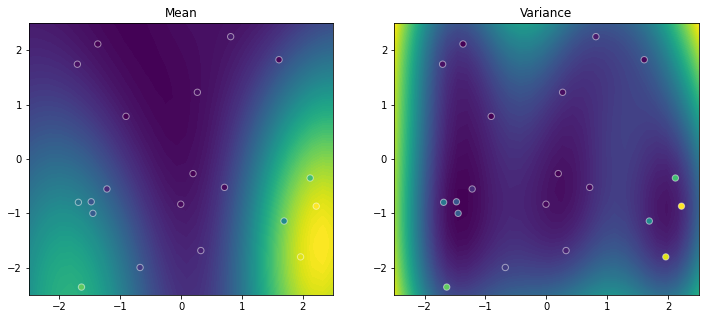

In [161]:
X1,X2,mean_grid,var_grid = evaluate_complete_posterior(m,bounds)
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].set_title('Mean')
axs[1].set_title('Variance')
axs[0].contourf(X1,X2,mean_grid,100)
axs[1].contourf(X1,X2,var_grid,100)
for ax in axs:
	ax.scatter(X[:,0],X[:,1],c=Y, edgecolor = (1,1,1,0.5),s=40)
plt.show()

To optimize the **mean** of this GP, we need an objective function, which I will define as follows:

In [162]:
def gp_obj(x,m):
	'''
	Description: 
	Returns the mean prediction of a Gaussian process at a point, x. 

	Inputs:
	x - input to be evaluated as either a list or 1-D numpy array 
	m - model over which the mean is evaluated

	Outputs:
	mean - the mean of the Gaussian process posterior at x.
	'''
	mean,var = gp_inference(x,m)
	mean = mean.item()
	var = var.item()
	return mean


To optimize I will use ```scipy.minimize```

In [163]:
x0 = [0,0] # initial guess for optimal solution
res = minimize(gp_obj,x0,args=(m),bounds=bounds) # optimize the function gp_obj
x_opt = res.x # return the optimal inputs
f_opt = res.fun # return the optimal function value

# print results
print('optimal x: ',x_opt)
print('optimal f(x): ',f_opt)

optimal x:  [-0.84837059  2.5       ]
optimal f(x):  -72.71314455293327


For the sake of completeness we will plot our optimal solution against the model for verification.

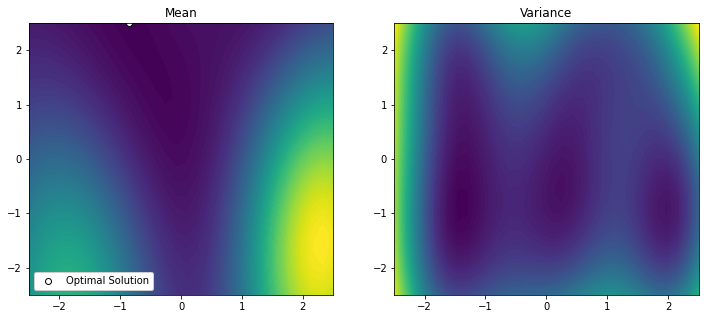

In [164]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].set_title('Mean')
axs[1].set_title('Variance')
axs[0].contourf(X1,X2,mean_grid,100)
axs[1].contourf(X1,X2,var_grid,100)
axs[0].scatter(x_opt[0],x_opt[1],c='w',edgecolor='k',label='Optimal Solution')
axs[0].legend(framealpha=1,loc='lower left')
plt.show()

Your task, is to optimize the Rosenbrock function using as few function evaluations as possible using Bayesian optimisation. 
You will need to think about creating an initial Gaussian process, optimizing some objective (you may have to change the above ```gp_obj``` function), and iterating the proceedure. 

E.g. 
1. Sample points in bounds 
2. Create GP
3. Optimize some aquisition function 
4. Sample function 
5. Repeat from 2


Example functions have been given to help you out, including potential required inputs and outputs. You may wish to change these. 

In [ ]:
def sample(bounds):
	'''
	your code here
	'''
	return X 

In [165]:
def create_gp(X,Y):
	'''
	your code here
	'''
	return m

In [ ]:
def aquisition_function(x,m):
	'''
	your code here
	'''
	return aq_value

In [ ]:
def optimize_aquisition(m,aquisition_function,bounds):
	'''
	your code here
	'''
	return optimal_input

In [ ]:
def add_sample(optimal_input,X,Y):
	'''
	your code here
	'''
	return new_X,new_Y